In [96]:
import matplotlib.pyplot as plt
import matplotlib.transforms as transforms

import numpy as np
import pandas as pd
import seaborn as sns

from scipy.spatial import distance

from sklearn import preprocessing
from sklearn.linear_model import ElasticNetCV
from sklearn.neighbors import NearestCentroid
from sklearn.preprocessing import (
    MinMaxScaler, Normalizer, PowerTransformer, QuantileTransformer, RobustScaler, StandardScaler)


In [97]:
df = pd.read_csv('../data/unsw/UNSW_NB15_training-set.csv')

df.head(1)


,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.000011,udp,-,INT,2,0,496,0,90909.0902,...,1,2,0,0,0,1,2,0,Normal,0


In [98]:
# encode categorical features
le = preprocessing.LabelEncoder()
df['proto'] = le.fit_transform(df['proto'])
df['service'] = le.fit_transform(df['service'])
df['state'] = le.fit_transform(df['state'])

df.head(1)


,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.000011,117,0,4,2,0,496,0,90909.0902,...,1,2,0,0,0,1,2,0,Normal,0


In [99]:
# separate features from labels
X = df.drop(['id', 'label', 'attack_cat'], axis=1)
X.columns = X.iloc[0]

y = le.fit_transform(df['attack_cat'])

y_label_map = dict(zip(le.classes_, le.transform(le.classes_)))

X.shape, y.shape


((82332, 42), (82332,))

In [100]:
# scale data using different scalers and compare

# data normalizer
scaler = Normalizer().fit(X)
X_normalizer = scaler.transform(X)

# min-madf scaler
scaler = MinMaxScaler().fit(X)
X_minmax = scaler.transform(X)

# robust scaler
scaler = RobustScaler().fit(X)
X_robust = scaler.transform(X)

# standard scaler
scaler = StandardScaler().fit(X)
X_standard = scaler.transform(X)

# quantile transformer
scaler = QuantileTransformer().fit(X)
X_quantile = scaler.transform(X)

# power transformer
scaler = PowerTransformer().fit(X)
X_power = scaler.transform(X)


In [101]:
# measure nearest shrunken centroid
def nearest_shrunken_centroid(X, y):
    clf = NearestCentroid(shrink_threshold=0.1)
    clf.fit(X, y)

    return clf.centroids_


In [102]:
# compute  Mahalanobis distance between the class centroids
def mahalanobis_distance(X, y):
    centroids = nearest_shrunken_centroid(X, y)
    distances = np.zeros((len(centroids), len(centroids)))

    for i in range(centroids.shape[0]):
        for j in range(centroids.shape[0]):
            if i != j:
                distances[i, j] = distance.mahalanobis(centroids[i], centroids[j], np.cov(X, rowvar=False))

    return distances


In [103]:
# compute the distance for unscaled data and each scaler's output

# unscaled data
distances = mahalanobis_distance(X, y)

# normalizer
distances_normalizer = mahalanobis_distance(X_normalizer, y)

# min-madf scaler
distances_minmax = mahalanobis_distance(X_minmax, y)

# robust scaler
distances_robust = mahalanobis_distance(X_robust, y)

# standard scaler
distances_standard = mahalanobis_distance(X_standard, y)

# quantile transformer
distances_quantile = mahalanobis_distance(X_quantile, y)

# power transformer
distances_power = mahalanobis_distance(X_power, y)


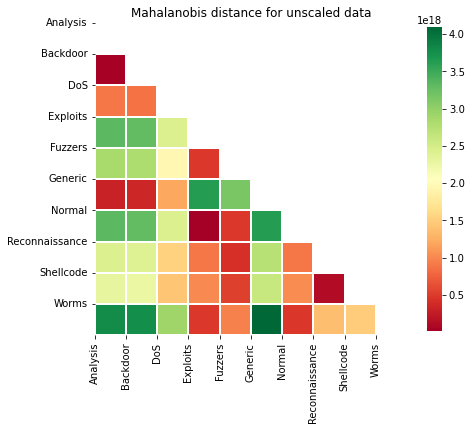

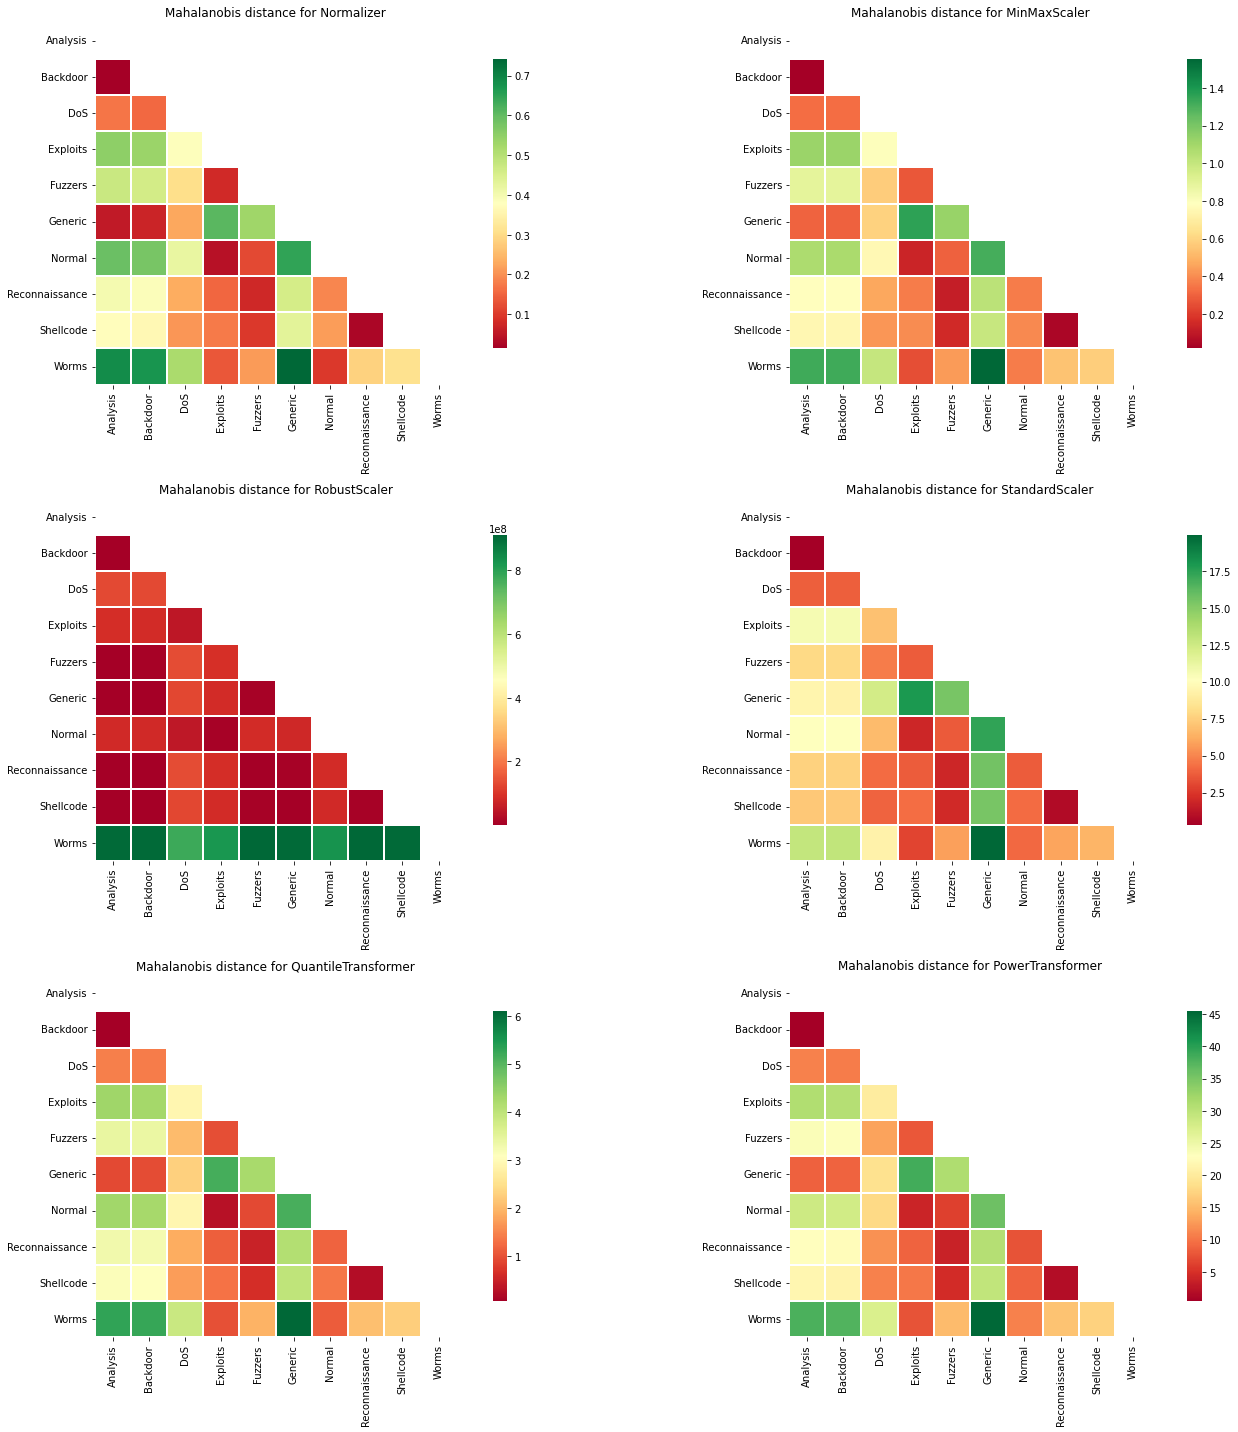

In [104]:
# plot heatmap for each set of distances

# create a boolean mask to remove redundant values from the plot
mask = np.zeros_like(distances)
mask[np.triu_indices_from(mask)] = True


def heatmap(data, ax=None, title=''):
    sns.heatmap(data, cmap='RdYlGn', mask=mask, ax=ax, linewidths=2, cbar_kws={'shrink': .8}, square=True)
    if ax:
        ax.set_title(title)
        ax.set_xticklabels(y_label_map.keys(), rotation=90)
        ax.set_yticklabels(y_label_map.keys(), rotation=0)


# unscaled data
plt.figure(figsize=(7, 7))
heatmap(distances)
plt.title('Mahalanobis distance for unscaled data')
plt.xticks(range(len(y_label_map)), y_label_map.keys(), rotation=90)
plt.yticks(range(len(y_label_map)), y_label_map.keys(), rotation=0)
plt.show()

# scaled data
fig, axis = plt.subplots(3, 2, figsize=(20, 20))

# normalizer
heatmap(distances_normalizer, ax=axis[0, 0], title='Mahalanobis distance for Normalizer')

# min-max
heatmap(distances_minmax, ax=axis[0, 1], title='Mahalanobis distance for MinMaxScaler')

# robust
heatmap(distances_robust, ax=axis[1, 0], title='Mahalanobis distance for RobustScaler')

# standard
heatmap(distances_standard, ax=axis[1, 1], title='Mahalanobis distance for StandardScaler')

# quantile
heatmap(distances_quantile, ax=axis[2, 0], title='Mahalanobis distance for QuantileTransformer')

# power
heatmap(distances_power, ax=axis[2, 1], title='Mahalanobis distance for PowerTransformer')

fig.tight_layout()
plt.show()


In [105]:
# apply ElasticNetCV on the min-max output 5 times with cross-validation and calculate MSE

model = ElasticNetCV(cv=5, random_state=0)
model.fit(X_minmax, y)


ElasticNetCV(cv=5, random_state=0)

In [106]:
alpha = model.alpha_
alphas = model.alphas_
mse = model.mse_path_
alphas_path, coef, _ = model.path(X_minmax, y)


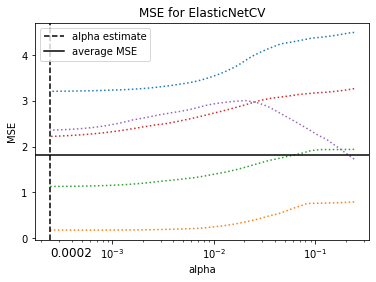

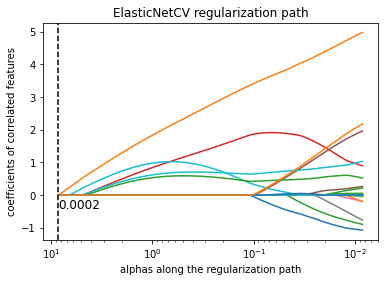

In [107]:
# plot the results

# mse plot with final alpha and mse highlighted
plt.figure()
plt.semilogx(alphas, mse)
plt.setp(plt.gca().get_lines(), linestyle=':')
plt.title('MSE for ElasticNetCV')
plt.axvline(alpha, color='black', label='alpha estimate', linestyle='--')
plt.axhline(mse.mean(axis=1).min(), color='black', label='average MSE')
plt.text(alpha, -.4, '{:.4f}'.format(alpha), {'color': 'black', 'fontsize': 12})

plt.legend()
plt.xlabel('alpha')
plt.ylabel('MSE')
plt.show()

# plot the regularization path for elastic net presenting the informative features
plt.figure()
plt.title('ElasticNetCV regularization path')
plt.semilogx(alphas_path, coef.T)
plt.axvline((np.max(alphas_path) - alpha), color='black', linestyle='--')
plt.text((np.max(alphas_path) - alpha), -0.4, '{:.4f}'.format(alpha),
         {'color': 'black', 'fontsize': 12})

plt.gca().invert_xaxis() # rectify plot direction
plt.xlabel('alphas along the regularization path')
plt.ylabel('coefficients of correlated features')
plt.show()


In [123]:
# display the list of features selected by Elastic Net as a table
selected_features_idx = np.where(model.coef_ != 0)
selected_features = pd.DataFrame({'feature': df.columns[selected_features_idx], 'coefficient': model.coef_[selected_features_idx]})
selected_features = selected_features[selected_features.coefficient != 0].sort_values('coefficient')
selected_features = selected_features.reset_index(drop=True)

selected_features

,feature,coefficient
0,service,-6.854740
1,ct_flw_http_mthd,-3.513834
2,sttl,-2.583881
3,ct_src_ltm,-1.888289
4,smean,-1.341144
5,dload,-0.898459
6,dinpkt,-0.871584
7,dtcpb,-0.802945
8,ct_src_dport_ltm,-0.770895
9,ackdat,-0.754281
